In [1]:
import torch
from chronos import ChronosPipeline

# Initialize pipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    torch_dtype=torch.bfloat16,
)

# Create sample input
context = torch.randn(1, 100)  # Single time series of length 100
prediction_length = 12  # Number of steps to predict

# B: Get tokenized input
# Reference: MeanScaleUniformBins.context_input_transform()
token_ids, attention_mask, tokenizer_state = pipeline.tokenizer.context_input_transform(context)
print("B - Tokenized shape:", token_ids.shape)

# C: Get encoder embeddings
# Reference: ChronosModel.encode()
encoder_output = pipeline.model.encode(
    input_ids=token_ids.to(pipeline.model.device),
    attention_mask=attention_mask.to(pipeline.model.device)
)
print("C - Encoder output shape:", encoder_output.shape)

# D: Get decoder output with prediction length
# Create decoder input with start token
decoder_input_ids = torch.full(
    (token_ids.shape[0], prediction_length),  # [batch_size, prediction_length]
    fill_value=pipeline.model.model.config.decoder_start_token_id,
    device=encoder_output.device
)

decoder_output = pipeline.model.model.decoder(
    input_ids=decoder_input_ids,
    encoder_hidden_states=encoder_output,
    encoder_attention_mask=attention_mask.to(encoder_output.device),
    return_dict=True
)
print("D - Decoder output shape:", decoder_output.last_hidden_state.shape)

# E: Get output tokens using the language modeling head
lm_logits = pipeline.model.model.lm_head(decoder_output.last_hidden_state)
print("E - Output token logits shape:", lm_logits.shape)



/home/arda/anaconda3/envs/chronos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


B - Tokenized shape: torch.Size([1, 101])


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


C - Encoder output shape: torch.Size([1, 101, 768])
D - Decoder output shape: torch.Size([1, 12, 768])
E - Output token logits shape: torch.Size([1, 12, 4096])


In [3]:
# Example with shape [12, 64, 4096]
import torch
from chronos import ChronosPipeline

# Initialize pipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cuda" if torch.cuda.is_available() else "cpu", 
    torch_dtype=torch.bfloat16,
)

# Create sample input with batch size 12 and sequence length 64
context = torch.randn(12, 64)  # [batch_size=12, seq_len=64]
prediction_length = 12

# Get tokenized input
token_ids, attention_mask, tokenizer_state = pipeline.tokenizer.context_input_transform(context)
print("Tokenized shape:", token_ids.shape)  # Expected: [12, 64]

# Get encoder embeddings
encoder_output = pipeline.model.encode(
    input_ids=token_ids.to(pipeline.model.device),
    attention_mask=attention_mask.to(pipeline.model.device)
)
print("Encoder output shape:", encoder_output.shape)  # Expected: [12, 64, hidden_size]

# Create decoder input with start token
decoder_input_ids = torch.full(
    (token_ids.shape[0], prediction_length),  # [12, prediction_length]
    fill_value=pipeline.model.model.config.decoder_start_token_id,
    device=encoder_output.device
)

# Get decoder output
decoder_output = pipeline.model.model.decoder(
    input_ids=decoder_input_ids,
    encoder_hidden_states=encoder_output,
    encoder_attention_mask=attention_mask.to(encoder_output.device),
    return_dict=True
)
print("Decoder output shape:", decoder_output.last_hidden_state.shape)  # Expected: [12, prediction_length, hidden_size]

# Get logits from language modeling head
lm_logits = pipeline.model.model.lm_head(decoder_output.last_hidden_state)
print("Logits shape:", lm_logits.shape)  # Expected: [12, prediction_length, vocab_size=4096]
import torch.nn.functional as F
# Apply softmax to get probabilities
probs = F.softmax(lm_logits, dim=-1)
print("Probabilities shape:", probs.shape)  # Expected: [12, prediction_length, vocab_size=4096]
distill_loss = -(probs * probs).sum(dim=-1).mean()


Tokenized shape: torch.Size([12, 65])
Encoder output shape: torch.Size([12, 65, 768])
Decoder output shape: torch.Size([12, 12, 768])
Logits shape: torch.Size([12, 12, 4096])
Probabilities shape: torch.Size([12, 12, 4096])


In [9]:
distill_loss = -(probs * probs).sum(dim=-1)
distill_loss.mean()

tensor(-0.0125, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)

In [11]:
distill_loss.sum()/12

tensor(-0.1494, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)

In [18]:
lm_logits.shape

torch.Size([1, 12, 4096])

In [19]:
import torch.nn as nn
nn.KLDivLoss(reduction="none")(F.log_softmax(lm_logits, dim=-1), F.softmax(lm_logits, dim=-1)).sum()/12

tensor(-0.0063, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)

In [20]:
nn.KLDivLoss(reduction="batchmean")(F.log_softmax(lm_logits, dim=-1), F.softmax(lm_logits, dim=-1))


tensor(-0.0063, device='cuda:0', dtype=torch.bfloat16, grad_fn=<DivBackward0>)

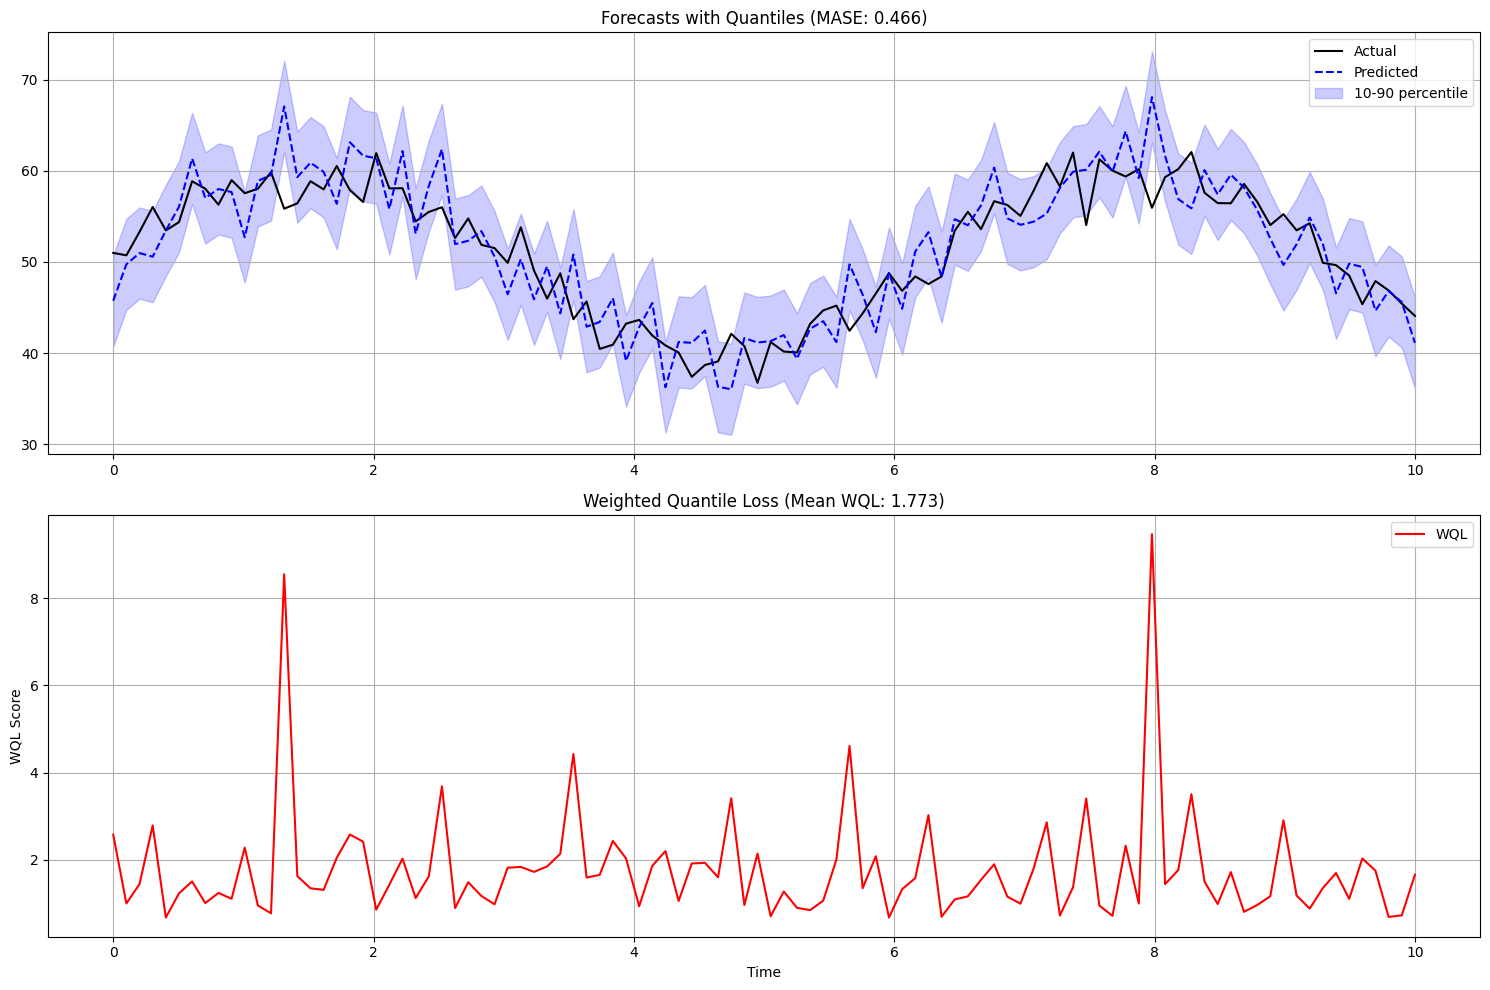


Summary Statistics:
MASE Score: 0.466
Mean WQL Score: 1.773
Min WQL Score: 0.672
Max WQL Score: 9.469

Detailed calculation for first point:
Actual value: 50.99
Predicted value: 45.75
Predicted quantiles (10%, 50%, 90%): 40.75, 45.75, 50.75
WQL score: 2.57


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

def calculate_mase(y_true: np.ndarray, y_pred: np.ndarray, seasonality: int = 1) -> float:
    """
    Calculate Mean Absolute Scaled Error
    
    Args:
        y_true: Actual values
        y_pred: Predicted values
        seasonality: Seasonal period (default=1 for non-seasonal data)
    """
    # Calculate errors
    errors = np.abs(y_true - y_pred)
    
    # Calculate seasonal naive errors (scale)
    seasonal_errors = np.abs(y_true[seasonality:] - y_true[:-seasonality])
    scale = np.mean(seasonal_errors)
    
    # Handle division by zero
    if scale == 0:
        return np.inf
        
    return np.mean(errors) / scale

def calculate_wql(y_true: float, quantiles: List[float], 
                 quantile_levels: List[float]) -> float:
    """
    Calculate Weighted Quantile Loss
    
    Args:
        y_true: Actual value
        quantiles: List of predicted quantiles
        quantile_levels: List of quantile levels (e.g., [0.1, 0.5, 0.9])
    """
    losses = []
    for q, tau in zip(quantiles, quantile_levels):
        if y_true > q:
            loss = 2 * tau * (y_true - q)
        else:
            loss = 2 * (1 - tau) * (q - y_true)
        losses.append(loss)
    return np.mean(losses)

# Generate sample data
np.random.seed(42)
t = np.linspace(0, 10, 100)
true_signal = 10 * np.sin(t) + 50
noise = np.random.normal(0, 2, size=len(t))
y_true = true_signal + noise

# Generate forecasts
y_pred = true_signal + np.random.normal(0, 3, size=len(t))  # Point forecasts

# Generate quantile forecasts
q10 = y_pred - 5
q50 = y_pred
q90 = y_pred + 5

# Calculate MASE
mase_score = calculate_mase(y_true, y_pred, seasonality=10)

# Calculate WQL for each point
wql_scores = []
for i in range(len(y_true)):
    wql = calculate_wql(
        y_true[i], 
        [q10[i], q50[i], q90[i]], 
        [0.1, 0.5, 0.9]
    )
    wql_scores.append(wql)

# Plot results
plt.figure(figsize=(15, 10))

# Plot 1: Actual vs Predicted with quantiles
plt.subplot(2, 1, 1)
plt.plot(t, y_true, label='Actual', color='black')
plt.plot(t, y_pred, label='Predicted', color='blue', linestyle='--')
plt.fill_between(t, q10, q90, alpha=0.2, color='blue', label='10-90 percentile')
plt.title(f'Forecasts with Quantiles (MASE: {mase_score:.3f})')
plt.legend()
plt.grid(True)

# Plot 2: WQL scores
plt.subplot(2, 1, 2)
plt.plot(t, wql_scores, label='WQL', color='red')
plt.title(f'Weighted Quantile Loss (Mean WQL: {np.mean(wql_scores):.3f})')
plt.xlabel('Time')
plt.ylabel('WQL Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"MASE Score: {mase_score:.3f}")
print(f"Mean WQL Score: {np.mean(wql_scores):.3f}")
print(f"Min WQL Score: {np.min(wql_scores):.3f}")
print(f"Max WQL Score: {np.max(wql_scores):.3f}")

# Show example calculations for a single point
i = 0  # First point
print("\nDetailed calculation for first point:")
print(f"Actual value: {y_true[i]:.2f}")
print(f"Predicted value: {y_pred[i]:.2f}")
print(f"Predicted quantiles (10%, 50%, 90%): {q10[i]:.2f}, {q50[i]:.2f}, {q90[i]:.2f}")
print(f"WQL score: {wql_scores[i]:.2f}")

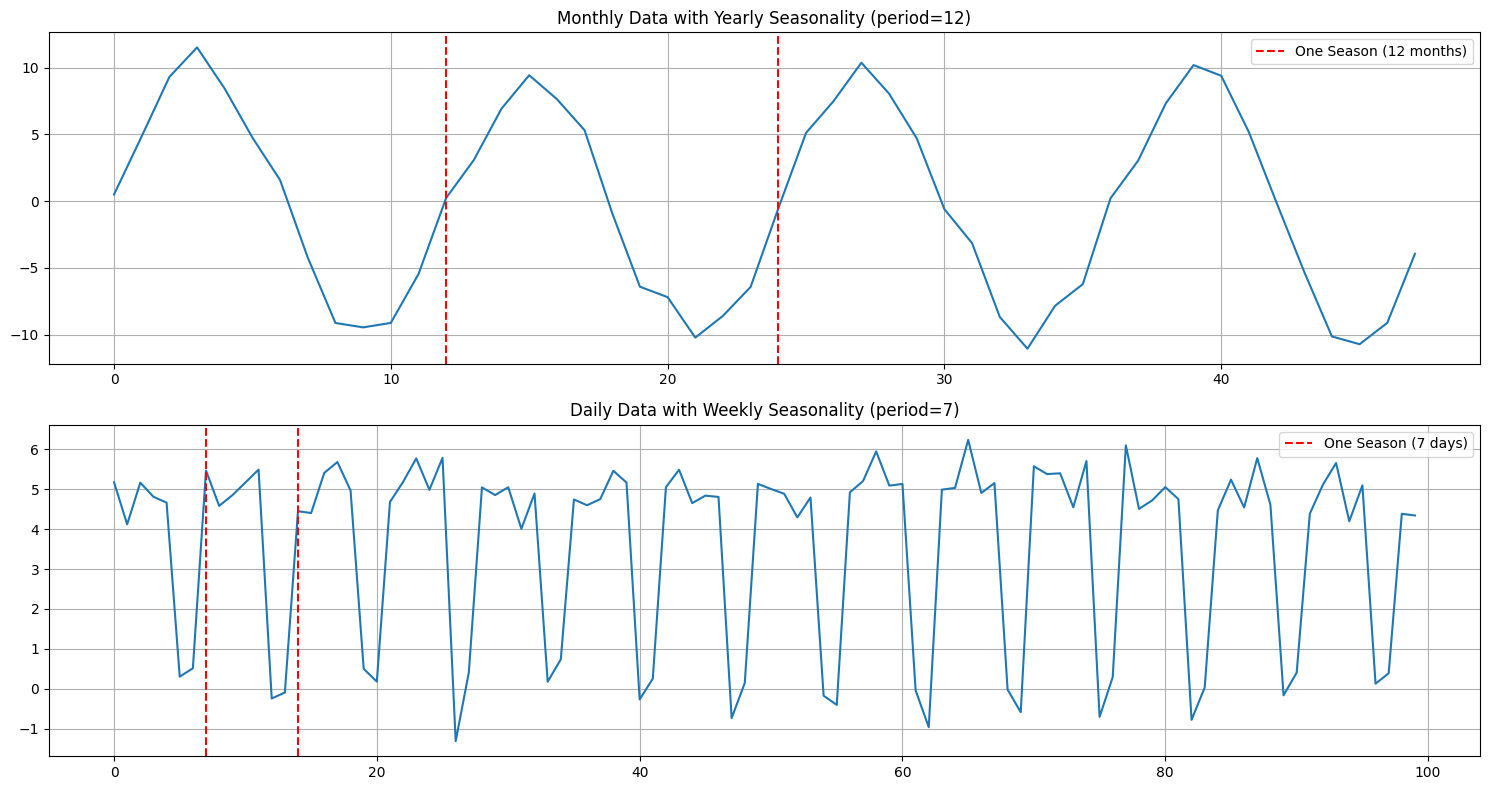

Monthly Data Example:

Seasonality period: 12
First few seasonal differences:
t=12: |y_12 - y_0| = |0.24 - 0.50| = 0.25
t=13: |y_13 - y_1| = |3.09 - 4.86| = 1.78
t=14: |y_14 - y_2| = |6.94 - 9.31| = 2.37
t=15: |y_15 - y_3| = |9.44 - 11.52| = 2.09
t=16: |y_16 - y_4| = |7.65 - 8.43| = 0.78

Scale factor (mean seasonal difference): 1.16
MASE: 0.31

Seasonality period: 1
First few seasonal differences:
t=1: |y_1 - y_0| = |4.86 - 0.50| = 4.37
t=2: |y_2 - y_1| = |9.31 - 4.86| = 4.45
t=3: |y_3 - y_2| = |11.52 - 9.31| = 2.22
t=4: |y_4 - y_3| = |8.43 - 11.52| = 3.10
t=5: |y_5 - y_4| = |4.77 - 8.43| = 3.66

Scale factor (mean seasonal difference): 3.44
MASE: 0.10


0.10376541867893242

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create example time series with different seasonalities
np.random.seed(42)

# 1. Monthly data with yearly seasonality (period=12)
t = np.arange(48)  # 4 years of monthly data
monthly_seasonal = 10 * np.sin(2 * np.pi * t / 12) + np.random.normal(0, 1, len(t))

# 2. Daily data with weekly seasonality (period=7)
t_daily = np.arange(100)  # 100 days
daily_seasonal = 5 * (t_daily % 7 < 5) + np.random.normal(0, 0.5, len(t_daily))  # Weekend effect

# Plot examples
plt.figure(figsize=(15, 8))

# Monthly data
plt.subplot(2, 1, 1)
plt.plot(t, monthly_seasonal)
plt.title('Monthly Data with Yearly Seasonality (period=12)')
plt.axvline(x=12, color='r', linestyle='--', label='One Season (12 months)')
plt.axvline(x=24, color='r', linestyle='--')
plt.grid(True)
plt.legend()

# Daily data
plt.subplot(2, 1, 2)
plt.plot(t_daily, daily_seasonal)
plt.title('Daily Data with Weekly Seasonality (period=7)')
plt.axvline(x=7, color='r', linestyle='--', label='One Season (7 days)')
plt.axvline(x=14, color='r', linestyle='--')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Now let's see how seasonality affects MASE calculation
def calculate_mase(y_true, y_pred, seasonality):
    """
    Calculate MASE with detailed steps
    """
    # 1. Calculate absolute errors
    errors = np.abs(y_true - y_pred)
    
    # 2. Calculate seasonal naive errors
    seasonal_errors = np.abs(y_true[seasonality:] - y_true[:-seasonality])
    
    # Print intermediate steps
    print(f"\nSeasonality period: {seasonality}")
    print(f"First few seasonal differences:")
    for i in range(min(5, len(seasonal_errors))):
        print(f"t={i+seasonality}: |y_{i+seasonality} - y_{i}| = |{y_true[i+seasonality]:.2f} - {y_true[i]:.2f}| = {seasonal_errors[i]:.2f}")
    
    scale = np.mean(seasonal_errors)
    mase = np.mean(errors) / scale
    
    print(f"\nScale factor (mean seasonal difference): {scale:.2f}")
    print(f"MASE: {mase:.2f}")
    
    return mase

# Example with monthly data
print("Monthly Data Example:")
y_true = monthly_seasonal
y_pred = monthly_seasonal + np.random.normal(0, 0.5, len(monthly_seasonal))  # Slightly noisy predictions

# Calculate MASE with different seasonality periods
calculate_mase(y_true, y_pred, seasonality=12)  # Yearly seasonality
calculate_mase(y_true, y_pred, seasonality=1)   # No seasonality

In [24]:
from chronos import ChronosPipeline
import torch
teacher = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-mini",
    device_map="cuda",
    torch_dtype=torch.float32,
).model.model


In [25]:
teacher

T5ForConditionalGeneration(
  (shared): Embedding(4096, 384)
  (encoder): T5Stack(
    (embed_tokens): Embedding(4096, 384)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=384, out_features=512, bias=False)
              (k): Linear(in_features=384, out_features=512, bias=False)
              (v): Linear(in_features=384, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=384, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=384, out_features=1536, bias=False)
              (wo): Linear(in_features=1536, out_features=384, bias=False)
              (dropout): Dropou

In [26]:

from transformers import (
    AutoModelForSeq2SeqLM,
    AutoModelForCausalLM,
    AutoConfig,
    T5Config,
    Trainer,
    TrainingArguments,
)

def load_model(
    model_id="google/t5-efficient-tiny",
    model_type="seq2seq",
    vocab_size=4096,
    random_init=False,
    tie_embeddings=False,
    pad_token_id=0,
    eos_token_id=1,
):
    """
    Load the specified HuggingFace model, adjusting the vocabulary
    size, special token IDs, and initialization options.

    This allows to set a model up for training on a new vocabulary
    of tokens.
    """
    assert model_type in ["seq2seq", "causal"]
    AutoModelClass = (
        AutoModelForSeq2SeqLM if model_type == "seq2seq" else AutoModelForCausalLM
    )
    if random_init:
        config = AutoConfig.from_pretrained(model_id)
        if isinstance(config, T5Config):
            # The default initializer_factor (1.0) in transformers is too large
            config.initializer_factor = 0.05
        config.tie_word_embeddings = tie_embeddings
        model = AutoModelClass.from_config(config)
    else:
        model = AutoModelClass.from_pretrained(model_id)

    model.resize_token_embeddings(vocab_size)

    model.config.pad_token_id = model.generation_config.pad_token_id = pad_token_id
    model.config.eos_token_id = model.generation_config.eos_token_id = eos_token_id

    return model

In [27]:
student = load_model(
    model_id="google/t5-efficient-mini",
    model_type="seq2seq",
    vocab_size=4096,
    random_init=True,
    tie_embeddings=True,
    pad_token_id=0,
    eos_token_id=1,
)

In [28]:
student

T5ForConditionalGeneration(
  (shared): Embedding(4096, 384)
  (encoder): T5Stack(
    (embed_tokens): Embedding(4096, 384)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=384, out_features=512, bias=False)
              (k): Linear(in_features=384, out_features=512, bias=False)
              (v): Linear(in_features=384, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=384, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=384, out_features=1536, bias=False)
              (wo): Linear(in_features=1536, out_features=384, bias=False)
              (dropout): Dropou

In [29]:
student_architecture = student.config.to_dict()
teacher_architecture = teacher.config.to_dict()

if student_architecture == teacher_architecture:
    print("Student and teacher have the same architecture.")
else:
    different_keys = set(student_architecture.keys()).symmetric_difference(teacher_architecture.keys())
    print(f"Student and teacher have different architectures. Different keys: {different_keys}")
    for key in different_keys:
        if key in student_architecture:
            print(f"Student's {key}: {student_architecture[key]}")
        if key in teacher_architecture:
            print(f"Teacher's {key}: {teacher_architecture[key]}")


Student and teacher have different architectures. Different keys: {'chronos_config'}
Teacher's chronos_config: {'tokenizer_class': 'MeanScaleUniformBins', 'tokenizer_kwargs': {'low_limit': -15.0, 'high_limit': 15.0}, 'n_tokens': 4096, 'n_special_tokens': 2, 'pad_token_id': 0, 'eos_token_id': 1, 'use_eos_token': True, 'model_type': 'seq2seq', 'context_length': 512, 'prediction_length': 64, 'num_samples': 20, 'temperature': 1.0, 'top_k': 50, 'top_p': 1.0}


In [38]:
teacher_architecture['chronos_config']

{'tokenizer_class': 'MeanScaleUniformBins',
 'tokenizer_kwargs': {'low_limit': -15.0, 'high_limit': 15.0},
 'n_tokens': 4096,
 'n_special_tokens': 2,
 'pad_token_id': 0,
 'eos_token_id': 1,
 'use_eos_token': True,
 'model_type': 'seq2seq',
 'context_length': 512,
 'prediction_length': 64,
 'num_samples': 20,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0}

In [37]:
student_architecture['chronos_config']


KeyError: 'chronos_config'

In [35]:
student_architecture

{'vocab_size': 4096,
 'd_model': 384,
 'd_kv': 64,
 'd_ff': 1536,
 'num_layers': 4,
 'num_decoder_layers': 4,
 'num_heads': 8,
 'relative_attention_num_buckets': 32,
 'relative_attention_max_distance': 128,
 'dropout_rate': 0.1,
 'classifier_dropout': 0.0,
 'layer_norm_epsilon': 1e-06,
 'initializer_factor': 0.05,
 'feed_forward_proj': 'relu',
 'use_cache': True,
 'dense_act_fn': 'relu',
 'is_gated_act': False,
 'return_dict': True,
 'output_hidden_states': False,
 'output_attentions': False,
 'torchscript': False,
 'torch_dtype': 'float32',
 'use_bfloat16': False,
 'tf_legacy_loss': False,
 'pruned_heads': {},
 'tie_word_embeddings': True,
 'chunk_size_feed_forward': 0,
 'is_encoder_decoder': True,
 'is_decoder': False,
 'cross_attention_hidden_size': None,
 'add_cross_attention': False,
 'tie_encoder_decoder': False,
 'max_length': 20,
 'min_length': 0,
 'do_sample': False,
 'early_stopping': False,
 'num_beams': 1,
 'num_beam_groups': 1,
 'diversity_penalty': 0.0,
 'temperature': 1.